In [19]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import joblib
import re

In [63]:
# 加载数据
file_path = "E:\竞赛\服创赛-A08\\data\\特征集\\new_features.csv"
data = pd.read_csv(file_path)

# file_path = "E:\竞赛\服创赛-A08\data\\analyzed_data_2.csv"
# data = pd.read_csv(file_path)

# 展示数据的前几行以及基本信息
# data.head(), data.info(), data.describe()

In [64]:
delete_feature = ['Unnamed: 0','个人编码']
data = data.drop(delete_feature,axis=1)

In [65]:
# 删除高度相关的特征（>0.9）--可选
# data = data.drop(columns=['月就诊天数_MAX', '月就诊天数_AVG', '月就诊医院数_MAX'])

In [66]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
# 应用Random Under Sampler
rus = RandomUnderSampler(random_state=42,sampling_strategy = {0: 1000, 1: 595})
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_rus.shape

(1595, 377)

In [84]:
 # 创建并训练模型
xgb = XGBClassifier(
                n_estimators=228,
                learning_rate=0.01,
                # max_depth=15,
                gamma=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                objective='binary:logistic',
                eval_metric='auc',
                use_label_encoder=False,
                random_state=42
            )

# 训练模型
xgb.fit(X_train_rus, y_train_rus)

# 预测
train_preds = xgb.predict(X_train_rus)
test_preds = xgb.predict(X_test)
train_proba = xgb.predict_proba(X_train_rus)[:, 1]
test_proba = xgb.predict_proba(X_test)[:, 1]

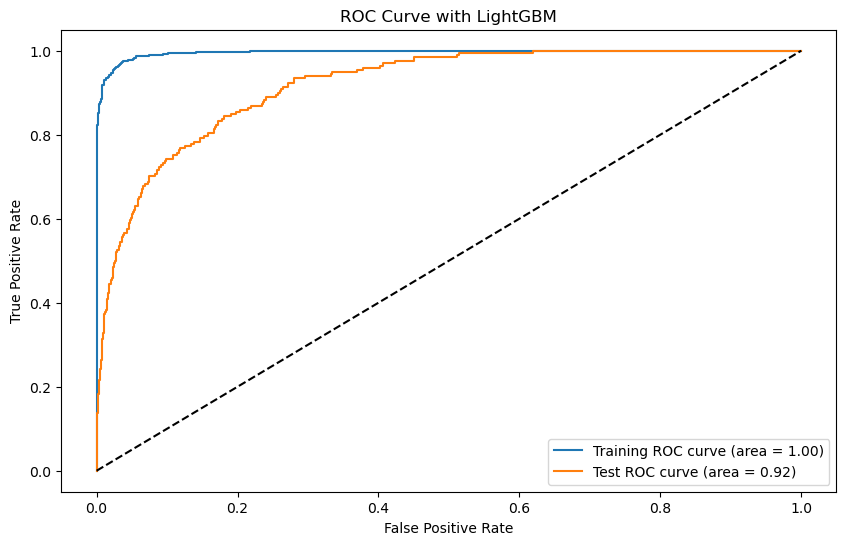

In [85]:
# 性能评估
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)
train_roc_auc = roc_auc_score(y_train_rus, train_proba)
test_roc_auc = roc_auc_score(y_test, test_proba)

# 绘制ROC曲线
fpr_train, tpr_train, _ = roc_curve(y_train_rus, train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {train_roc_auc:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with LightGBM')
plt.legend()
plt.show()

In [86]:
# Calculate the classification reports
train_classification_report = classification_report(y_train_rus, train_preds)
test_classification_report = classification_report(y_test, test_preds)

# Print the classification reports
print("Training Set Classification Report:\n", train_classification_report)
print("\nTest Set Classification Report:\n", test_classification_report)

Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.97      0.95      0.96       595

    accuracy                           0.97      1595
   macro avg       0.97      0.96      0.97      1595
weighted avg       0.97      0.97      0.97      1595


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      3802
           1       0.26      0.74      0.39       198

    accuracy                           0.89      4000
   macro avg       0.62      0.82      0.66      4000
weighted avg       0.95      0.89      0.91      4000



In [87]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.9178143879616789


In [88]:
# 获取特征重要性
feature_importances = xgb.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
feature_importances = np.array(X.columns)[sorted_idx][:10]

feature_importances

array(['月统筹金额_MAX_调整', '月统筹金额_MAX', '药品费发生金额_SUM_病种平均费用差',
       '药品费申报金额_SUM_病种平均费用差', '本次审批金额_SUM_病种平均费用差',
       '基本统筹基金支付金额_SUM_病种平均费用差', '月统筹金额_MAX_病种费用标准差值', 'ALL_SUM_病种平均费用差',
       'ALL_SUM_调整', '基本统筹基金支付金额_SUM_调整'], dtype=object)